Title:

Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

In [105]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [106]:
#loads data from the original source on the web 
titles_data <- read_csv("https://github.com/sm020402/dsci-100-2022w1-group-98/raw/main/project_proposal/data/titles.csv")

#filter out only movies from the data and select only the number column
titles_movie_data <- titles_data %>%
    filter(type == "MOVIE") %>%
    select(runtime, release_year, tmdb_popularity,imdb_score, imdb_votes, tmdb_popularity, tmdb_score)

Rows: 5850 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): id, title, type, description, age_certification, genres, production...
dbl (7): release_year, runtime, seasons, imdb_score, imdb_votes, tmdb_popula...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [107]:
titles_missing_values <- 
sapply(titles_movie_data, function(x) sum(is.na(x))) #count missing values for every column in dataset
titles_missing_values   

runtime    release_year tmdb_popularity      imdb_score      imdb_votes 
              0               0              62             315             331 
     tmdb_score 
            195

In [108]:
titles_movie <- na.omit(titles_movie_data) 

In [109]:
set.seed(1)
titles_split <- initial_split(titles_movie, prop = 0.75 , strata = tmdb_popularity)
titles_training <- training(titles_split)
titles_testing <- testing(titles_split)
titles_training
titles_testing

runtime,release_year,tmdb_popularity,imdb_score,imdb_votes,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
97,1972,1.268,6.2,418,6.1
133,1979,1.370,7.2,1727,6.0
129,1969,1.265,8.1,1958,8.5
⋮,⋮,⋮,⋮,⋮,⋮
64,2021,34.522,4.7,53,7.6
25,2021,53.762,5.6,38,6.3
90,2021,26.005,3.8,68,6.3


runtime,release_year,tmdb_popularity,imdb_score,imdb_votes,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
114,1976,40.965,8.2,808582,8.179
117,1966,13.123,7.3,16446,7.100
115,1954,8.915,7.5,42488,7.200
⋮,⋮,⋮,⋮,⋮,⋮
148,2021,1.978,5.1,1497,5.3
92,2021,1.971,6.8,1007,7.5
101,2021,1.748,5.0,136,6.7


In [110]:
titles_mean <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(mean, na.rm = TRUE)
titles_mean

titles_max <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(max, na.rm = TRUE)

titles_min <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(min, na.rm = TRUE)

titles_range <- titles_max - titles_min
titles_range

runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
101.6157,6.272379,28741.47,21.31249,6.461674


runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223,7.5,2294226,2273.444,9


Warning message:
“Removed 246 rows containing missing values (geom_point).”


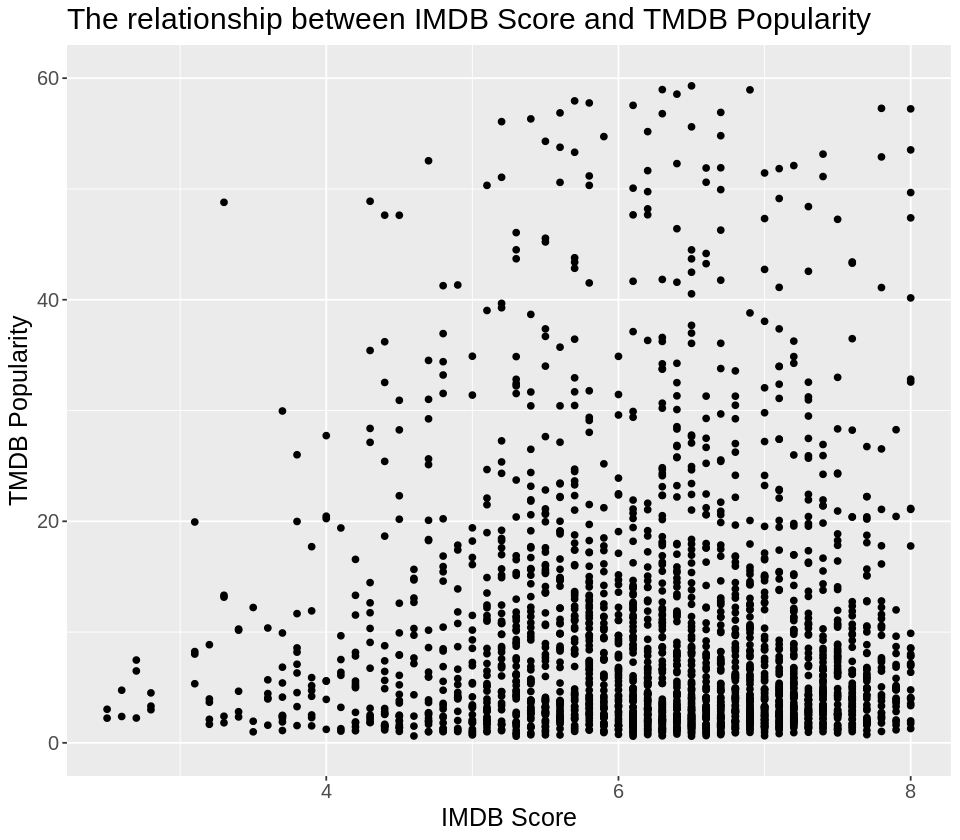

In [111]:
options(repr.plot.width = 8, repr.plot.height = 7) 
iscore_plot <- titles_training %>%
    ggplot(aes(x = imdb_score, y = tmdb_popularity)) +
    geom_point() +
    labs(x = "IMDB Score", y = "TMDB Popularity") +
    ylim(0,60)+
    xlim(2.5,8)+
    ggtitle("The relationship between IMDB Score and TMDB Popularity")+
    theme(text = element_text(size = 15))

iscore_plot

Warning message:
“Removed 1371 rows containing missing values (geom_point).”


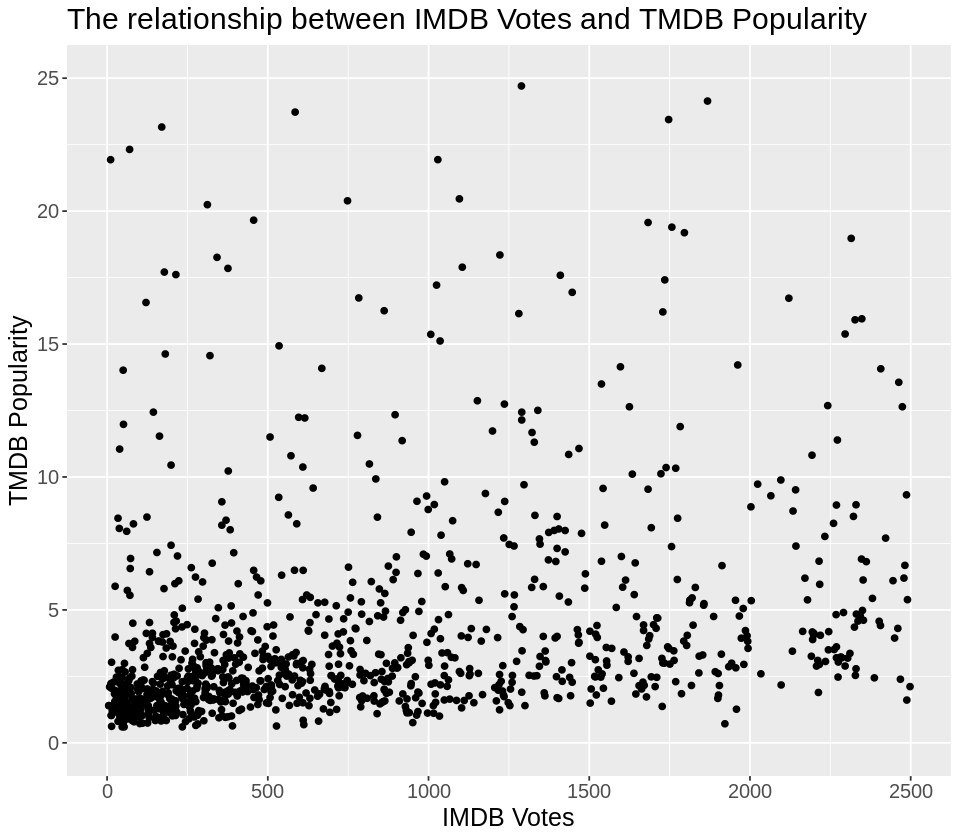

In [112]:
options(repr.plot.width = 8, repr.plot.height = 7) 
ivotes_plot <- titles_training %>%
    ggplot(aes(x = imdb_votes, y = tmdb_popularity)) +
    geom_point() +
    labs(x = "IMDB Votes", y ="TMDB Popularity") +
    ggtitle("The relationship between IMDB Votes and TMDB Popularity")+
    ylim(0,25)+
    xlim(0,2500)+
    theme(text = element_text(size = 15))

ivotes_plot

Warning message:
“Removed 177 rows containing missing values (geom_point).”


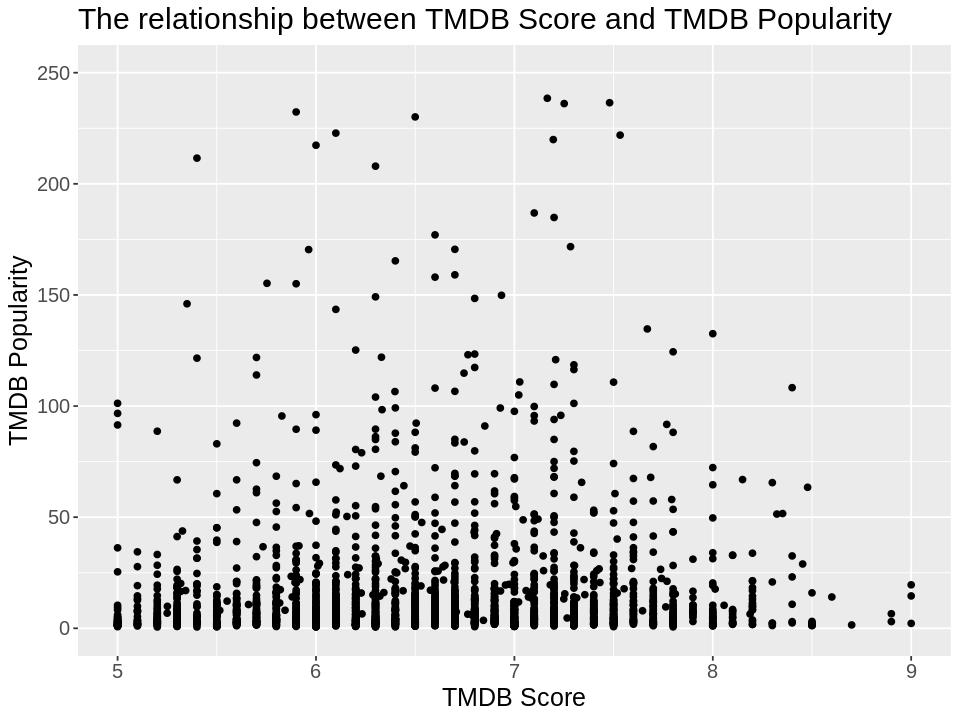

In [113]:
options(repr.plot.width = 8, repr.plot.height = 6) 
tscore_plot <- titles_training %>%
    ggplot(aes(x = tmdb_score , y = tmdb_popularity)) +
    geom_point() +
    labs(x = "TMDB Score", y ="TMDB Popularity") +
    ggtitle("The relationship between TMDB Score and TMDB Popularity")+
    ylim(0,250)+
    xlim(5,9)+
    theme(text = element_text(size = 15))

tscore_plot

Warning message:
“Removed 365 rows containing missing values (geom_point).”


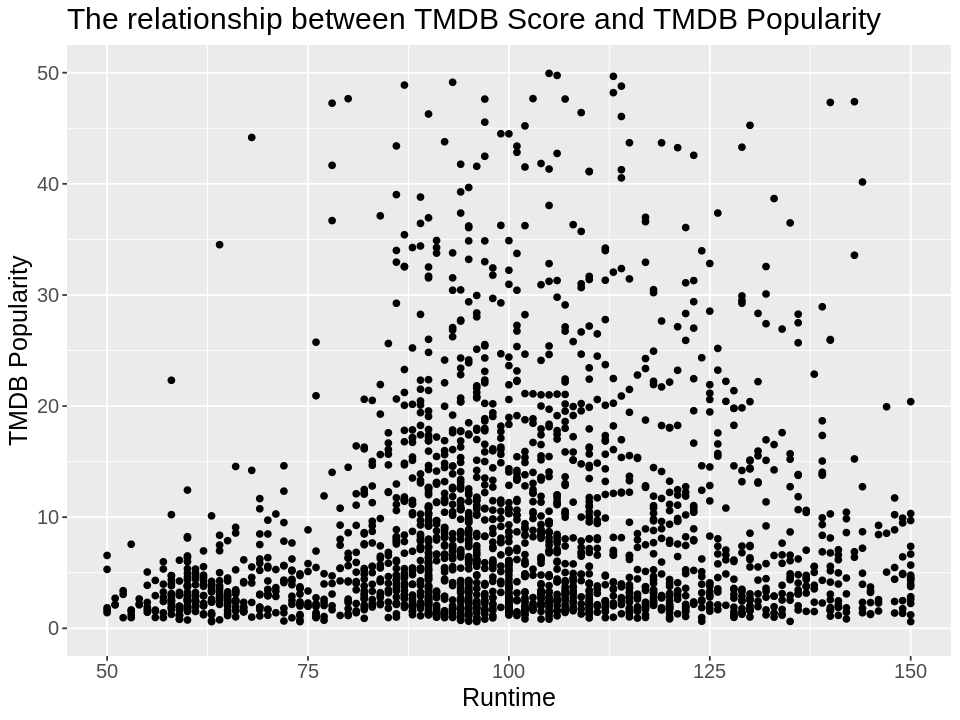

In [114]:
options(repr.plot.width = 8, repr.plot.height = 6) 
runtime_plot <- titles_training %>%
    ggplot(aes(x = runtime, y = tmdb_popularity)) +
    geom_point() +
    labs(x = "Runtime", y ="TMDB Popularity") +
    ggtitle("The relationship between TMDB Score and TMDB Popularity")+
    ylim(0,50)+
    xlim(50,150)+
    theme(text = element_text(size = 15))

runtime_plot

In [115]:
titles_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("regression")

titles_recipe <- recipe(tmdb_score ~ imdb_score + imdb_votes + tmdb_popularity , data = titles_training) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())
titles_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [116]:
set.seed(2)

titles_vfold <- vfold_cv(titles_training, v = 5, strata = tmdb_score)
titles_workflow <- workflow() %>%
    add_recipe(titles_recipe) %>%
    add_model(titles_spec)
titles_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [ ]:
gridvals <- tibble(neighbors = seq(from = 1, to = 200))
titles_results <- titles_workflow %>%
    tune_grid(resamples = titles_vfold, grid = gridvals) %>%
    collect_metrics()
titles_results

In [ ]:
titles_min <- titles_results %>%
   filter(.metric == "rmse") %>%
   arrange(mean)  %>%
   filter(mean == min(mean))
titles_min

In [ ]:
k_min <- titles_min %>%
    pull(neighbors)
titles_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("regression") 
titles_best_fit <- workflow() %>%
    add_recipe(titles_recipe) %>%
    add_model(titles_best_spec) %>%
    fit(data = titles_training)
titles_summary <- titles_best_fit %>%
    predict(titles_testing) %>%
    bind_cols(titles_testing) %>%
    metrics(truth = tmdb_score, estimate = .pred)
titles_summary

Methods & Results:
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 

note: all tables and figure should have a figure/table number and a legend

Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

References:
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.